In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys 
sys.path.insert(0, './MotorNet/')
import motornet as mn
import tensorflow as tf
from utils import Kernel_Gaussian
import torch


In [2]:
plant = mn.plants.ReluPointMass24()
print("Muscle Configuration:")
print(plant.get_muscle_cfg())

Muscle Configuration:
{'UpperRight': {'n_fixation_points': 2, 'fixation body': [0, 1], 'coordinates': [[2.0, 2.0], [0.0, 0.0]], 'max_isometric_force': 500}, 'UpperLeft': {'n_fixation_points': 2, 'fixation body': [0, 1], 'coordinates': [[-2.0, 2.0], [0.0, 0.0]], 'max_isometric_force': 500}, 'LowerRight': {'n_fixation_points': 2, 'fixation body': [0, 1], 'coordinates': [[2.0, -2.0], [0.0, 0.0]], 'max_isometric_force': 500}, 'LowerLeft': {'n_fixation_points': 2, 'fixation body': [0, 1], 'coordinates': [[-2.0, -2.0], [0.0, 0.0]], 'max_isometric_force': 500}}


2022-07-13 22:27:50.185817: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


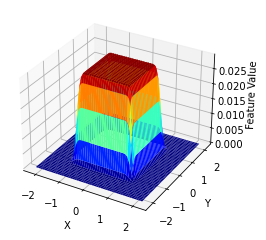

In [3]:
%matplotlib inline
x_range = np.array([-1.2,1.2])
y_range = np.array([-1.2,1.2])
n_kernel = 25
S = 0.01*np.eye(2)  
do_plot = 1
Kernel = Kernel_Gaussian(x_range, y_range, n_kernel, S, do_plot=1)


In [4]:
class SingleReach:
    def __init__(self, type):
        if type == 'fix':
            self.target_pos = np.array([0.5,0.6])
        if type == 'random':
            self.target_pos = (2*np.random.rand(2,1)) - 1

        self.target_size = 0.02
        self.dwell_time = 20
        self.hand_in = False
        self.trial_state = 0    # State of trial:  -1 loss, 0 still going, 1 Finished
        self.dwell_counter = 0
        self.screen = self.target_pos
        
    def get_reward(self, arm_pos):
        # Hand out of the target
        if np.linalg.norm(arm_pos-self.target_pos) >= self.target_size:
            if self.hand_in == True:
                self.reward = -10
                self.trial_state = -1
            else:
                self.reward = - np.linalg.norm(arm_pos-self.target_pos)
        # Hand in the target
        else:
            # First time
            if self.hand_in == False:
                self.reward = 0
                self.hand_in = True
                self.dwell_counter += 1
            # Has been in before
            else:
                if self.dwell_counter < self.dwell_time:
                    self.reward = 0
                    self.dwell_counter += 1
                else:
                    self.reward = 10
                    self.trial_state = 1
                    self.dwell_counter += 1
        return self.reward, self.target_pos, self.trial_state

In [5]:
class SeqEnv:
    def __init__(self, plant,visual_kernel, task, **kwargs):
        self.plant = plant
        self.task = task
        self.visual_kernel = visual_kernel
        self.plant.excitation_noise_sd=  kwargs.get('motor_noise_sd', 0)
        self.num_muscle = self.plant.n_muscles
        [self.joint_state, self.cart_state, self.muscle_state, self.geometry_state] = plant.get_initial_state(batch_size=1)

    def get_init_state(self):
        [self.joint_state, self.cart_state, self.muscle_state, self.geometry_state] = self.plant.get_initial_state()

        target_visual = self.visual_kernel.encode(self.task.target_pos[0].reshape(-1,1), self.task.target_pos[1].reshape(-1,1))
        hand_visual = self.visual_kernel.encode(self.cart_state.numpy()[0][0].reshape(-1,1), self.cart_state.numpy()[0][1].reshape(-1,1))
        self.visual_feedback = np.concatenate((hand_visual.reshape(Kernel.n_kernel,Kernel.n_kernel,1) , \
                                               target_visual.reshape(Kernel.n_kernel,Kernel.n_kernel,1)),axis=-1)
        return self.visual_feedback


    def step(self, muscle_input):
        [self.joint_state, self.cart_state, self.muscle_state, self.geometry_state] = \
        self.plant(tf.convert_to_tensor(muscle_input,dtype='float') ,self.joint_state, self.muscle_state, self.geometry_state)
        self.reward, self.target_pos, self.trial_state = self.task.get_reward(self.cart_state.numpy()[0][:2])

        target_visual = self.visual_kernel.encode(self.target_pos[0].reshape(-1,1), self.target_pos[1].reshape(-1,1))
        hand_visual = self.visual_kernel.encode(self.cart_state.numpy()[0][0].reshape(-1,1), self.cart_state.numpy()[0][1].reshape(-1,1))
        self.visual_feedback = np.concatenate((hand_visual.reshape(Kernel.n_kernel,Kernel.n_kernel,1) , \
                                               target_visual.reshape(Kernel.n_kernel,Kernel.n_kernel,1)),axis=-1)
        
        return self.reward, self.visual_feedback, self.trial_state


In [22]:

class GRU_model(torch.nn.Module):

    def __init__(self):
        super(GRU_model, self).__init__()

        self.conv = torch.nn.Conv3d(in_channels=2, out_channels=1, kernel_size=(1,3,3))
        self.max_pool = torch.nn.MaxPool3d(kernel_size=(1,3,3))
        self.flatten = torch.nn.Flatten(start_dim=-2, end_dim=-1)
        self.gru_layer = torch.nn.GRU(input_size=49, hidden_size=30, num_layers=1, bias=False, bidirectional=False, batch_first=True)
        self.linear1 = torch.nn.Linear(30, 4)
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.max_pool(x)
        x = self.flatten(x)
        x = torch.squeeze(x, dim = 1)
        x, h = self.gru_layer(x, torch.randn(1,1,30))
        x = self.linear1(x)
        x = self.activation(x)
        return x

model = GRU_model()

print('The model:')
print(model)

def loss_fc(reward):
    return -1 *  torch.sum(reward)

def discount_rewards(rewards, gamma=0.99):
    lenr = len(rewards)
    disc_return = torch.pow(gamma,torch.arange(lenr).float()) * rewards   
    disc_return /= disc_return.max() #Normalizes to 0,1
    return disc_return

The model:
GRU_model(
  (conv): Conv3d(2, 1, kernel_size=(1, 3, 3), stride=(1, 1, 1))
  (max_pool): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 3, 3), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (gru_layer): GRU(49, 30, bias=False, batch_first=True)
  (linear1): Linear(in_features=30, out_features=4, bias=True)
  (activation): ReLU()
)


In [27]:
Max_duration = 100
task = SingleReach(type='fix')
env = SeqEnv(plant, Kernel, task, motor_noise_sd = 0)
vis = env.get_init_state()
done = False 
transitions = [] # list of state, action, reward
with torch.no_grad():
    for t in range(Max_duration):
        vis_feedback = np.expand_dims(vis.transpose(2,0,1), axis=(0,2))
        action = model(torch.from_numpy(vis_feedback).float())
        action = np.squeeze(action.numpy())
        reward, new_vis, done = env.step(action)
        vis = new_vis.copy()
        transitions.append((new_vis, action, reward, t+1))
        if done != 0:
            print(done)
            break

inputs = torch.unsqueeze(torch.Tensor([vis for (vis, act, rew, t) in transitions]).permute(3,0,1,2),axis=0)
rewards = torch.Tensor([rew for (vis, act, rew, t) in transitions]).flip(dims=(0,))
rewards = discount_rewards(rewards)
pred_batch = model(inputs)



In [52]:
inputs = torch.unsqueeze(torch.Tensor([vis for (vis, act, rew, t) in transitions]).permute(3,0,1,2),axis=0)
rewards = torch.Tensor([rew for (vis, act, rew, t) in transitions]).flip(dims=(0,))
rewards = discount_rewards(rewards)
actions = torch.Tensor([act for (vis, act, rew, t) in transitions]).flip(dims=(0,))

#pred_batch = model(inputs)

In [59]:
torch.sum((pred_batch - actions))

tensor(-42.4298, grad_fn=<SumBackward0>)

In [ ]:

    reward_batch = torch.Tensor([r for (s,a,r) in transitions]).flip(dims=(0,))
   
    state_batch = torch.Tensor([s for (s,a,r) in transitions])
    action_batch = torch.Tensor([a for (s,a,r) in transitions])
    pred_batch = model(state_batch)
    prob_batch = pred_batch.gather(dim=1, index=action_batch.long().view(-1,1)).squeeze() # action prob associated with actual taken actions
    loss = loss_fn(prob_batch, disc_reward)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

torch.Size([100, 1, 2, 1, 25, 25])

In [16]:
transitions[10][2]

-0.5774557693033946

In [154]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

In [155]:
def discount_rewards(rewards, gamma=0.99):
    lenr = len(rewards)
    disc_return = torch.pow(gamma,torch.arange(lenr).float()) * rewards   
    disc_return /= disc_return.max() #Normalizes to 0,1
    return disc_return

def loss_fn(preds, r):
    return -1 * torch.sum(r * torch.log(preds))  # sum of action probability times reward


In [ ]:
# Define the network
l1 = env.observation_space.shape[0]
l2 = 150 # Hidden layer
l3 = 2
l1 = 4

model = torch.nn.Sequential(
torch.nn.Linear(l1, l2),
torch.nn.LeakyReLU(),
torch.nn.Linear(l2, l3),
torch.nn.Softmax()
)

learning_rate = 0.0009
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
Max_duration = 200
Max_episod = 2000
gamma = 0.9
score = []
for ep in tqdm(range(Max_episod)):
    state1 = env.reset()
    done = False 
    transitions = [] # list of state, action, reward
    for t in range(Max_duration):
        action_prob = model(torch.from_numpy(state1).float())
        action = np.random.choice(np.array([0, 1]), p=action_prob.data.numpy())
        state0 = state1.copy()
        state1 , _, done, info = env.step(action)
        transitions.append((state0, action, t+1))
        if done:
            break
        
    ep_len = len(transitions)
    score.append(ep_len)
    reward_batch = torch.Tensor([r for (s,a,r) in transitions]).flip(dims=(0,))
    disc_reward = discount_rewards(reward_batch)
    state_batch = torch.Tensor([s for (s,a,r) in transitions])
    action_batch = torch.Tensor([a for (s,a,r) in transitions])
    pred_batch = model(state_batch)
    prob_batch = pred_batch.gather(dim=1, index=action_batch.long().view(-1,1)).squeeze() # action prob associated with actual taken actions
    loss = loss_fn(prob_batch, disc_reward)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()